<a href="https://colab.research.google.com/github/DevanWestley/GacoanJogja/blob/main/ProjectRekdat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Rekdat : Queue Time Analysis for Gacoan Jogja**

### Compiled and made by Devan Westley

Dalam era modern, efisiensi waktu menjadi salah satu faktor penting yang memengaruhi kepuasan pelanggan terhadap sebuah layanan. Restoran cepat saji, khususnya yang memiliki tingkat kunjungan tinggi, sering menghadapi permasalahan terkait panjangnya waktu antrean. Salah satu contohnya adalah Gacoan Jogja, yang dikenal sebagai restoran populer dengan jumlah pengunjung sangat besar setiap harinya.Dengan demikian, akan dicari kapan waktu terbaik untuk berkunjung ke Gacoan Jogja dengan waktu tunggu yang lebih singkat pada rentang jam tertentu.

## Introduction

**Hari** : Indicates the day of the week (e.g., Monday, Tuesday).

**Jam** : Indicates the observation time in hours and minutes (format HH:MM, e.g., 04:00, 05:00).

**Cabang** : Refers to the restaurant branch location (e.g., Gejayan).

**Waktu antri** : Represents the estimated waiting time (numeric value, e.g., 5 minutes).

**Keterangan** : Provides a description of the queue condition ( “almost no waiting”, "waiting", "not open").

**Sumber**: The data source link or reference (e.g., Google Maps URL).

## Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import eig
from sklearn.metrics import r2_score
from scipy.integrate import quad

## Predefine Library

In [ ]:
def remove_outliers_iqr(df, cols):
    bounds = {}
    mask_outlier = pd.Series(False, index=df.index)

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        bounds[col] = (lower, upper)
        mask_outlier |= (df[col] < lower) | (df[col] > upper)

    return df[~mask_outlier], df[mask_outlier], bounds


def convert_jam(jam_str):
    h = int(jam_str.split(":")[0])
    if h >= 4:
        return h
    else:
        return h + 24


def manual_pca(X, target_dim=4):
    X = np.array(X, dtype=float)
    X_centered = X - np.mean(X, axis=0)
    N = X_centered.shape[0]
    C = (1/N) * X_centered.T @ X_centered

    eigvals, eigvecs = np.linalg.eig(C)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    eigvecs_reduced = eigvecs[:, :target_dim]
    X_reduced = X_centered @ eigvecs_reduced

    return X_reduced, C, eigvals, eigvecs

def fourier_fit_plot(x, y, n_harmonics=2):
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]

    N = len(x_sorted)
    X = np.ones((N, 1))
    for n in range(1, n_harmonics + 1):
        X = np.column_stack([X, np.sin(2 * np.pi * n * x_sorted / max(x_sorted))])
        X = np.column_stack([X, np.cos(2 * np.pi * n * x_sorted / max(x_sorted))])
    coeffs, _, _, _ = np.linalg.lstsq(X, y_sorted, rcond=None)
    y_pred = X @ coeffs

    r2 = r2_score(y_sorted, y_pred)

    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, color='blue', label='Data', alpha=0.7)
    plt.plot(x_sorted, y_pred, color='red', label=f'Fourier fit ({n_harmonics} harmonics)\nR² = {r2:.4f}', linewidth=2)
    plt.xlabel("Jam_encoded")
    plt.ylabel("Waktu antri")
    plt.title("Fourier Fit to Queue Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return coeffs, r2

def fourier_function_string(coeffs, x_max):
    terms = [f"{coeffs[0]:.4f}"]

    n_harmonics = (len(coeffs) - 1) // 2
    for n in range(1, n_harmonics + 1):
        A = coeffs[2*n - 1]
        B = coeffs[2*n]
        terms.append(f"{A:.4f}*sin({2*n}*pi*x/{x_max})")
        terms.append(f"{B:.4f}*cos({2*n}*pi*x/{x_max})")

    return " + ".join(terms)

results = []

## About Dataset

In [ ]:
df = pd.read_csv("Gacoan Jogja.csv",na_values=["-"])
df.head(1176)

,Hari,Jam,Cabang,Waktu antri,Keterangan,Sumber
0,Senin,4:00,Gejayan,5.0,nyaris tidak menunggu,https://share.google/FEUqtGKt4RvcAEaLP
1,Senin,5:00,Gejayan,5.0,nyaris tidak menunggu,https://share.google/FEUqtGKt4RvcAEaLP
2,Senin,6:00,Gejayan,5.0,nyaris tidak menunggu,https://share.google/FEUqtGKt4RvcAEaLP
3,Senin,7:00,Gejayan,5.0,nyaris tidak menunggu,https://share.google/FEUqtGKt4RvcAEaLP
4,Senin,8:00,Gejayan,5.0,nyaris tidak menunggu,https://share.google/FEUqtGKt4RvcAEaLP
...,...,...,...,...,...,...
1171,Minggu,23:00,Taman Siswa,75.0,menunggu,https://share.google/eUNT5NUDL8QvM34fK
1172,Minggu,0:00,Taman Siswa,45.0,menunggu,https://share.google/eUNT5NUDL8QvM34fK
1173,Minggu,1:00,Taman Siswa,30.0,menunggu,https://share.google/eUNT5NUDL8QvM34fK
1174,Minggu,2:00,Taman Siswa,15.0,menunggu,https://share.google/eUNT5NUDL8QvM34fK


In [ ]:
print("DataFrame shape (rows, columns):", df.shape)

DataFrame shape (rows, columns): (1176, 6)


In [ ]:
df.columns

Index(['Hari', 'Jam', 'Cabang', 'Waktu antri', 'Keterangan', 'Sumber'], dtype='object')

In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Hari             0
Jam              0
Cabang           0
Waktu antri    224
Keterangan       0
Sumber           0
dtype: int64


In [ ]:
df = df.dropna()

## Simple Feature Engineering

Hari = 0 - 6: Senin, Selasa ... Minggu


Jam = 4 - 27: 4, 5, 6, ...., 24, 1, 2, 3

cabang = 0-6: gejayan , barbasari , godean , jombor, kota baru, sono sewu, taman siswa

keterangan = 0-2: hampir tidak menunggu, menunggu, tidak buka

In [ ]:
df["Hari_encoded"], hari_mapping_arr = pd.factorize(df["Hari"])
hari_mapping = {c: i for i, c in enumerate(hari_mapping_arr)}
df["Jam_encoded"] = df["Jam"].apply(convert_jam)
df["Cabang_encoded"], cabang_mapping_arr = pd.factorize(df["Cabang"])
cabang_mapping = {c: i for i, c in enumerate(cabang_mapping_arr)}
df["Keterangan_encoded"], ket_mapping_arr = pd.factorize(df["Keterangan"])
ket_mapping = {c: i for i, c in enumerate(ket_mapping_arr)}
df["Sumber_encoded"], sumber_mapping_arr = pd.factorize(df["Sumber"])
sumber_mapping = {c: i for i, c in enumerate(sumber_mapping_arr)}

In [ ]:
after = pd.concat([
    df[["Hari_encoded", "Jam_encoded", "Cabang_encoded",
        "Waktu antri", "Keterangan_encoded", "Sumber_encoded"]].head(1176)
], axis=1)


after

,Hari_encoded,Jam_encoded,Cabang_encoded,Waktu antri,Keterangan_encoded,Sumber_encoded
0,0,4,0,5.0,0,0
1,0,5,0,5.0,0,0
2,0,6,0,5.0,0,0
3,0,7,0,5.0,0,0
4,0,8,0,5.0,0,0
...,...,...,...,...,...,...
1171,6,23,6,75.0,1,6
1172,6,24,6,45.0,1,6
1173,6,25,6,30.0,1,6
1174,6,26,6,15.0,1,6


## Outlier

In [ ]:
cleaned_after, outliers_after, bounds_after = remove_outliers_iqr(after, ["Waktu antri"])

print("=== Batas Outlier (Waktu antri) ===")
bounds_table = pd.DataFrame([bounds_after["Waktu antri"]],
                            columns=["Lower Bound", "Upper Bound"])
display(bounds_table)

print("=== 10 Data Pertama yang Bersih ===")
display(cleaned_after.head(1176))

print("=== 10 Data Pertama yang Outlier ===")
display(outliers_after.head(1176))


=== Batas Outlier (Waktu antri) ===


,Lower Bound,Upper Bound
0,-24.375,80.625


=== 10 Data Pertama yang Outlier ===


,Hari_encoded,Jam_encoded,Cabang_encoded,Waktu antri,Keterangan_encoded,Sumber_encoded
137,5,21,0,90.0,1,0
138,5,22,0,90.0,1,0
304,5,20,1,90.0,1,1
327,6,19,1,90.0,1,1
328,6,20,1,90.0,1,1
471,5,19,2,90.0,1,2
1146,5,22,6,90.0,1,6
1147,5,23,6,90.0,1,6


## Principal Component Analisis

In [ ]:
X_reduced, C, eigvals, eigvecs = manual_pca(cleaned_after, target_dim=4)

print("Covariance Matrix C:\n", C)
print("\nEigenvalues (diagonal of D):\n", eigvals)
print("\nEigenvectors (columns of V):\n", eigvecs)
print("\nReduced Data (6D → 4D):\n", X_reduced)

Covariance Matrix C:
 [[ 3.99043805e+00 -1.12308335e-01  3.85440606e-02  6.99705208e+00
   1.88646851e-02  3.85440606e-02]
 [-1.12308335e-01  3.83430363e+01 -7.20787848e-02  6.11967758e+01
   1.32642156e+00 -7.20787848e-02]
 [ 3.85440606e-02 -7.20787848e-02  4.46583238e+00  2.33690480e+00
   7.45251005e-02  4.46583238e+00]
 [ 6.99705208e+00  6.11967758e+01  2.33690480e+00  3.54869936e+02
   5.00505535e+00  2.33690480e+00]
 [ 1.88646851e-02  1.32642156e+00  7.45251005e-02  5.00505535e+00
   1.81537947e-01  7.45251005e-02]
 [ 3.85440606e-02 -7.20787848e-02  4.46583238e+00  2.33690480e+00
   7.45251005e-02  4.46583238e+00]]

Eigenvalues (diagonal of D):
 [ 3.66521351e+02  2.70402227e+01  8.87620126e+00  3.77710868e+00
  1.01728828e-01 -4.45508214e-16]

Eigenvectors (columns of V):
 [[-1.89125943e-02  5.99887850e-02 -1.21765811e-02 -9.97824089e-01
   1.55716771e-02 -8.57957135e-17]
 [-1.83301834e-01 -9.80667474e-01  3.57083324e-02 -5.61711555e-02
  -1.61697181e-02 -1.57310815e-16]
 [-6.390

Diperoleh eigenvalue 397, 27, 8.9, 3.7, 0.1, 0, dengan kesepakatan dimensi yang dibutuhkan hanya 4 supaya bisa dilakukan FFT, dipilih kolom dengan korespondensi eigenvalue terbesar yaitu **Hari_encoded, Jam_encoded, Cabang_encoded, dan Waktu antri**

In [ ]:
final = cleaned_after.drop(columns=["Keterangan_encoded", "Sumber_encoded"])

print("=== Final Data (setelah drop kolom) ===")
display(final.head(1176))

=== Final Data (setelah drop kolom) ===


,Hari_encoded,Jam_encoded,Cabang_encoded,Waktu antri
0,0,4,0,5.0
1,0,5,0,5.0
2,0,6,0,5.0
3,0,7,0,5.0
4,0,8,0,5.0
...,...,...,...,...
1171,6,23,6,75.0
1172,6,24,6,45.0
1173,6,25,6,30.0
1174,6,26,6,15.0


## Fast Fourier Transform

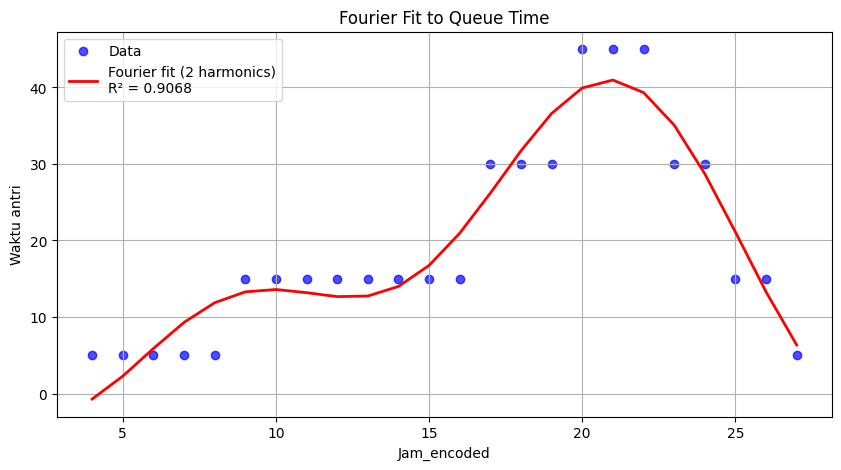

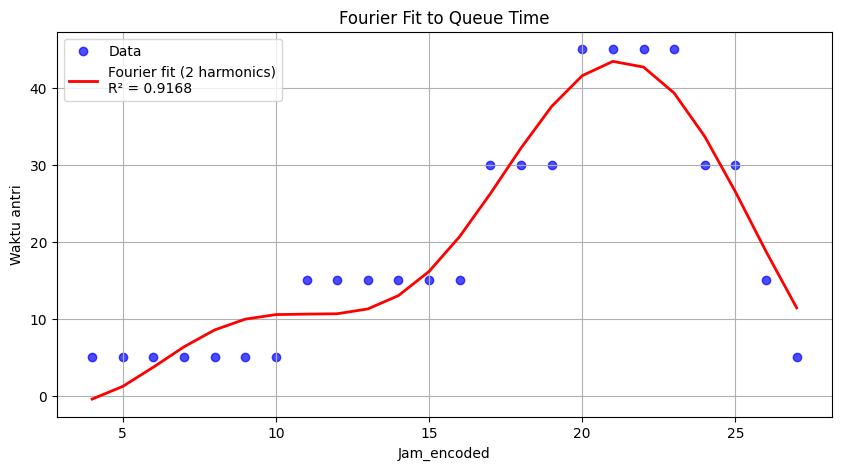

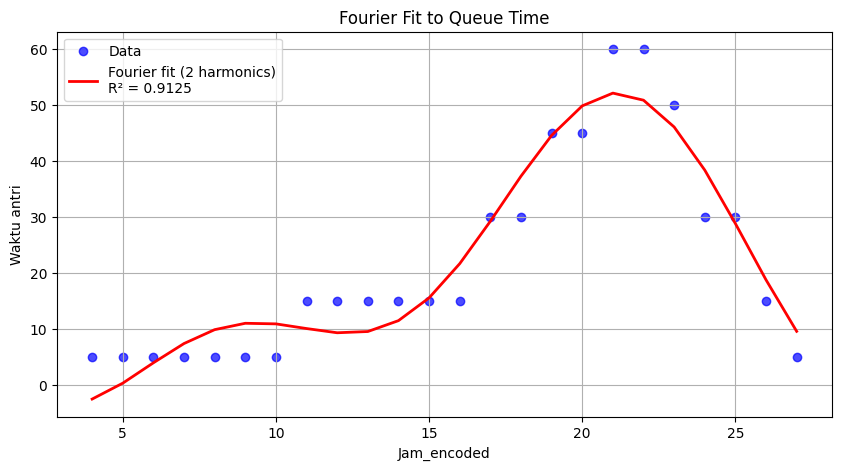

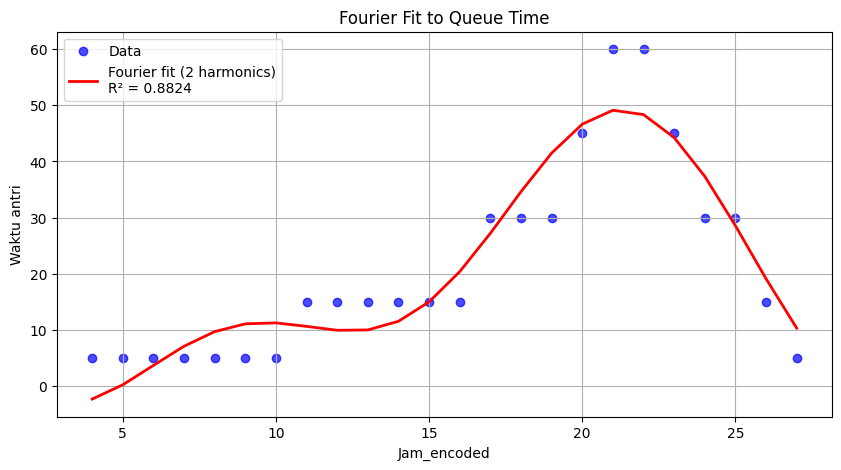

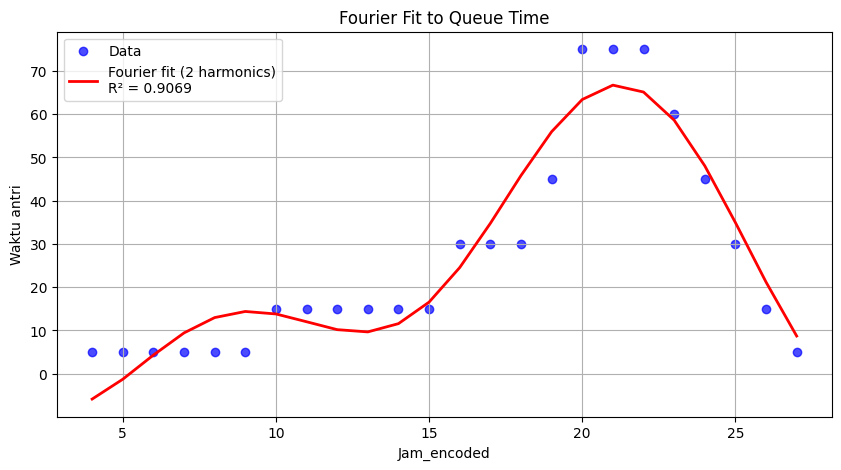

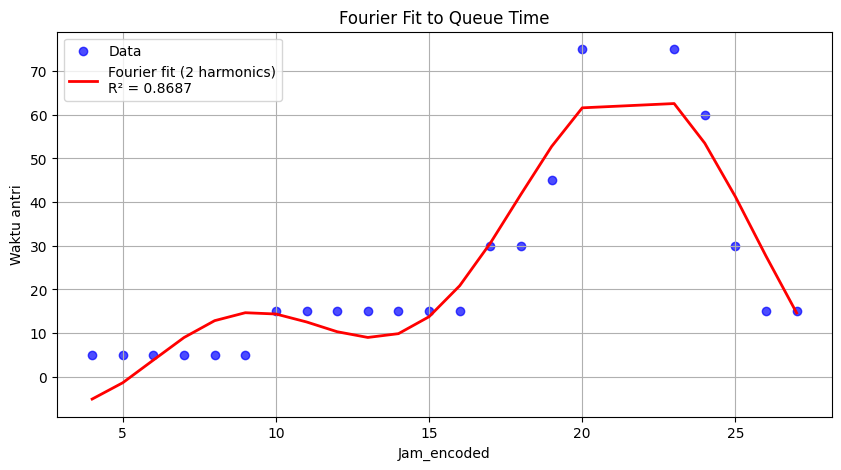

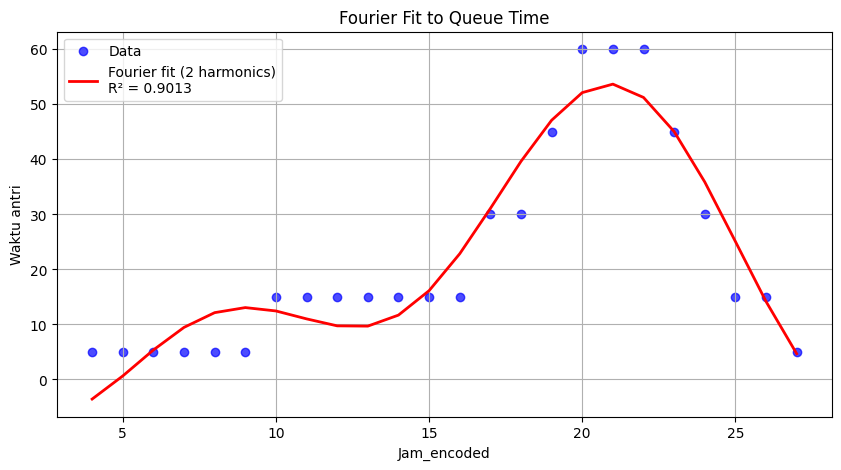

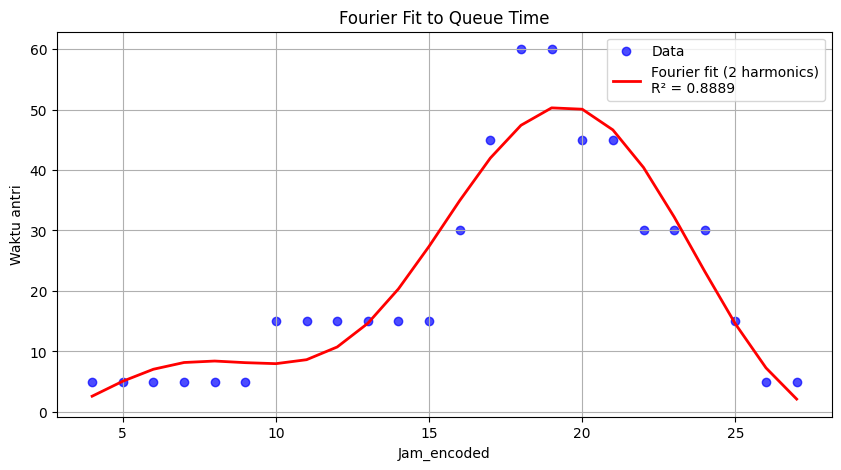

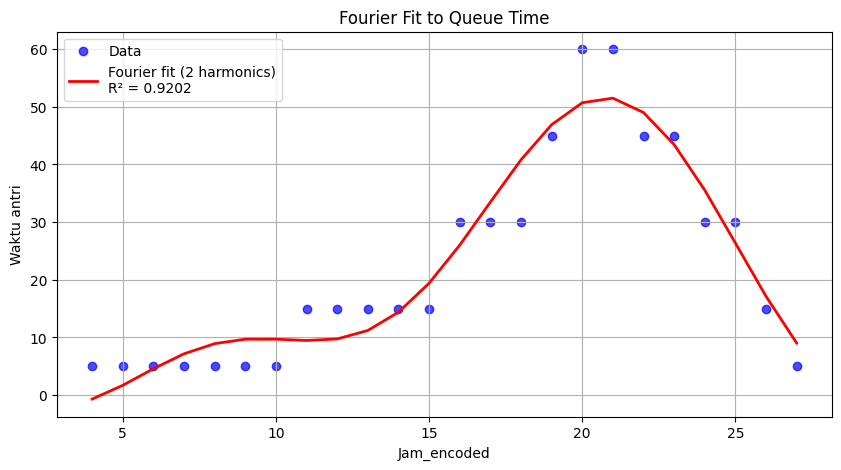

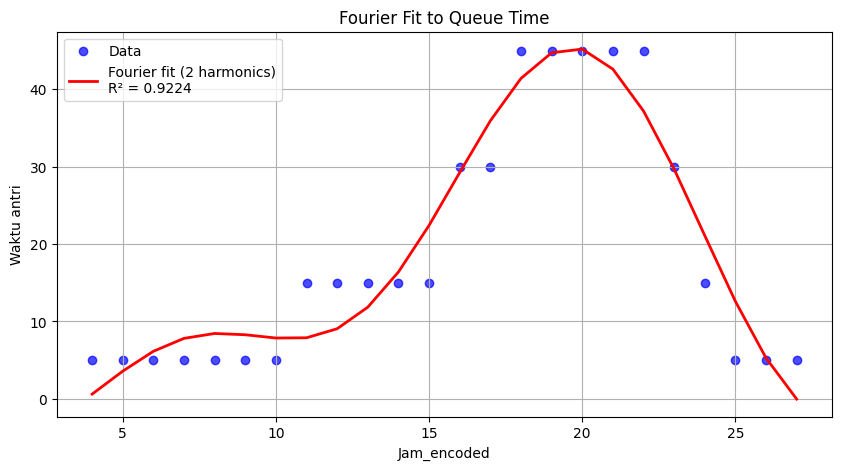

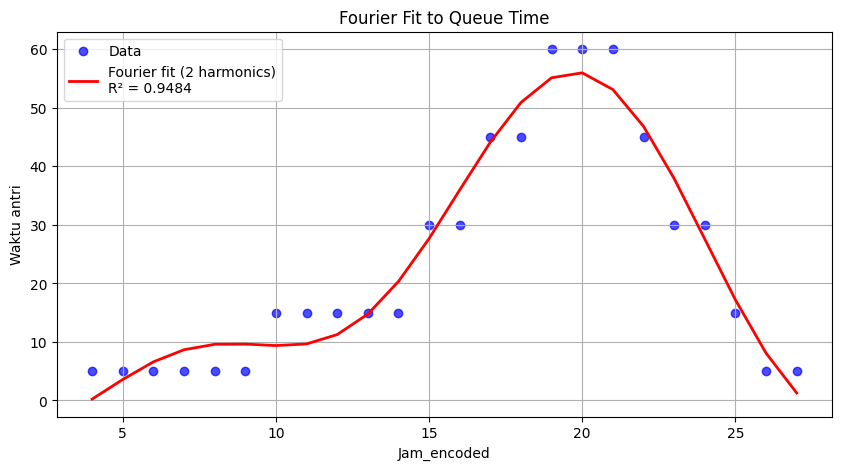

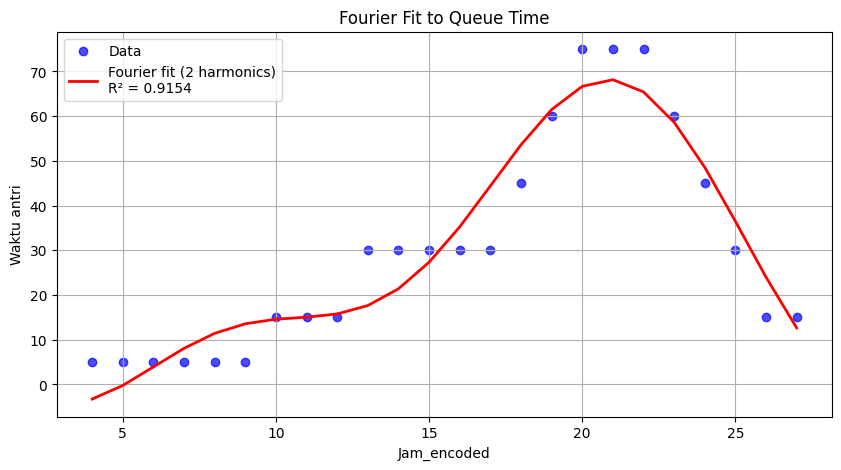

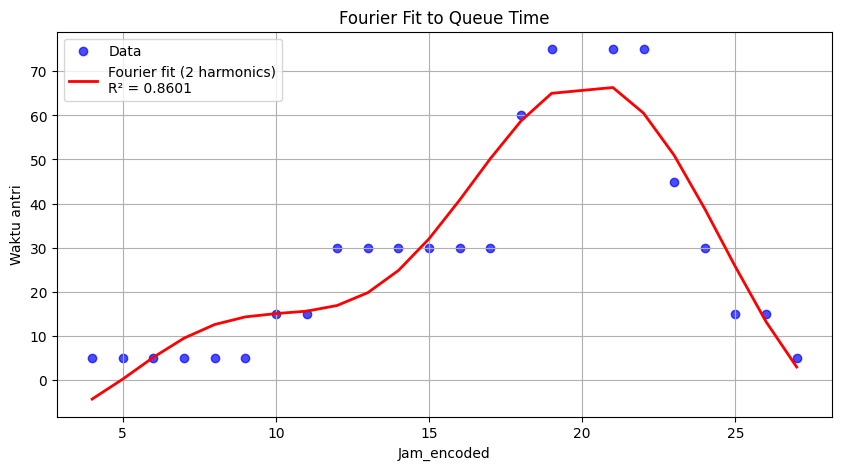

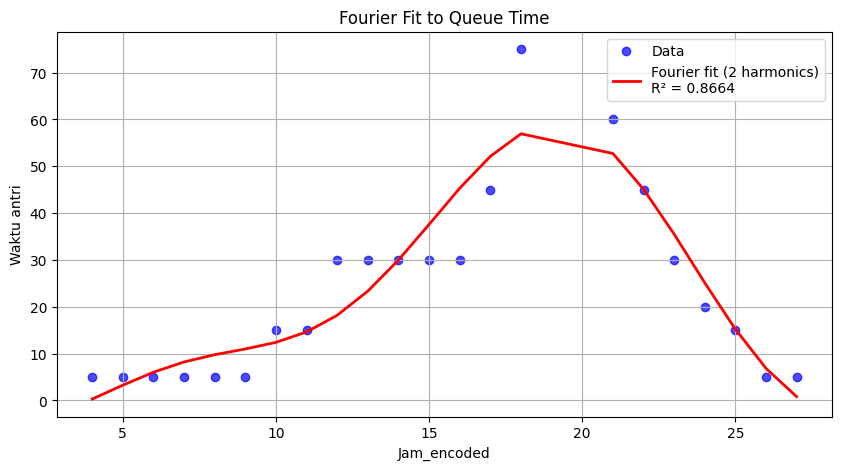

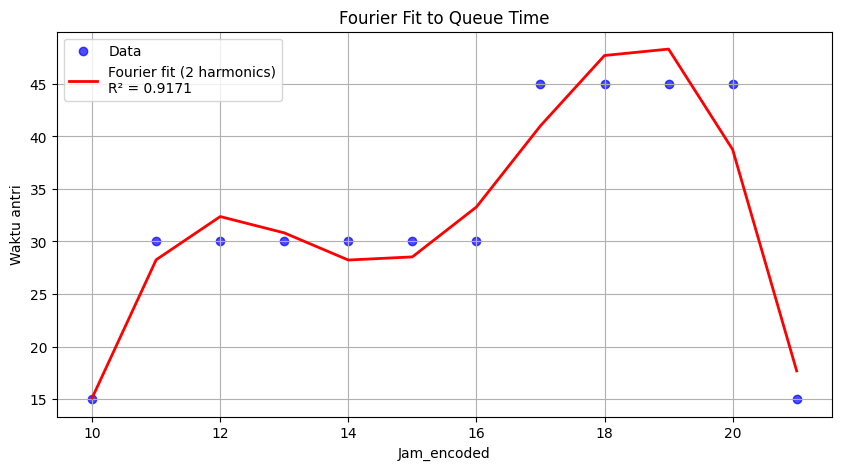

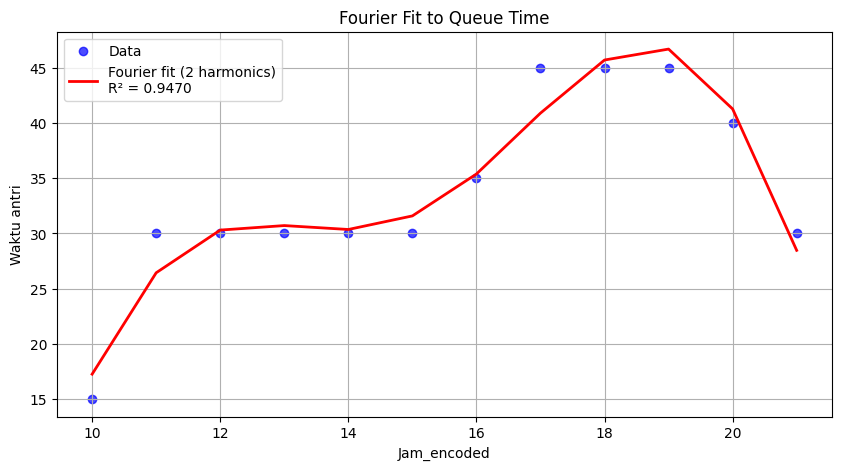

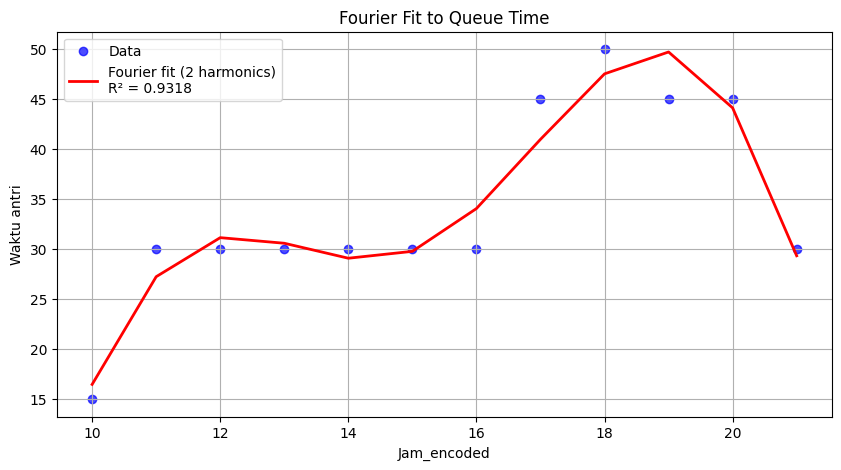

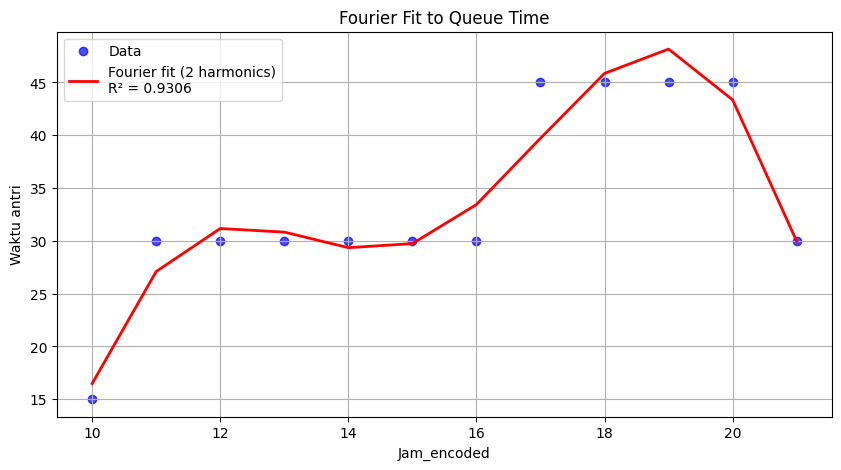

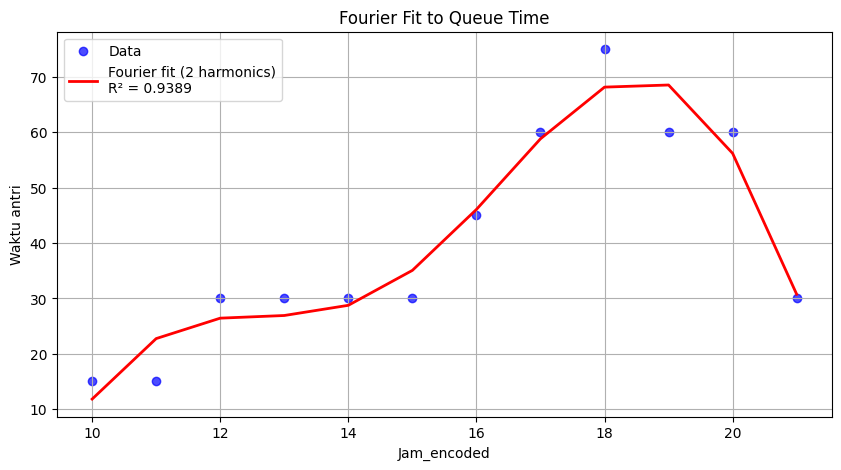

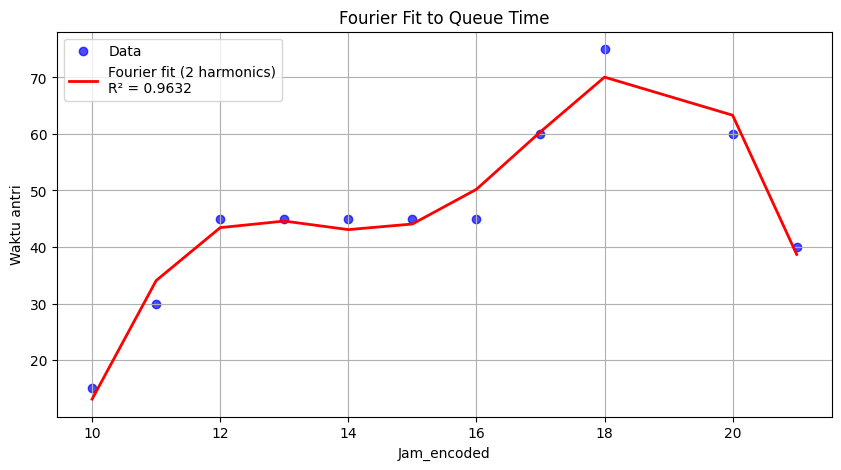

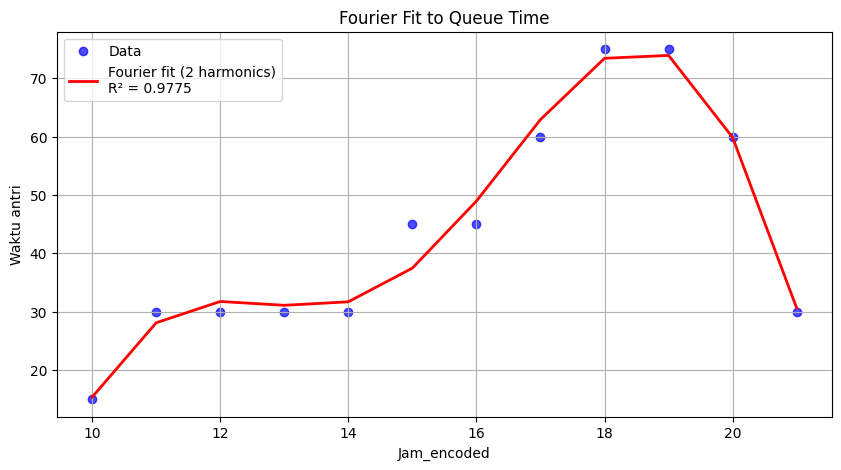

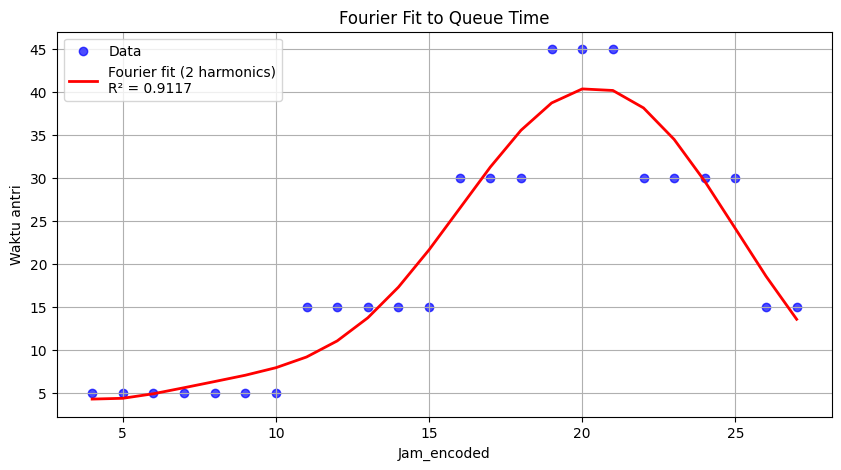

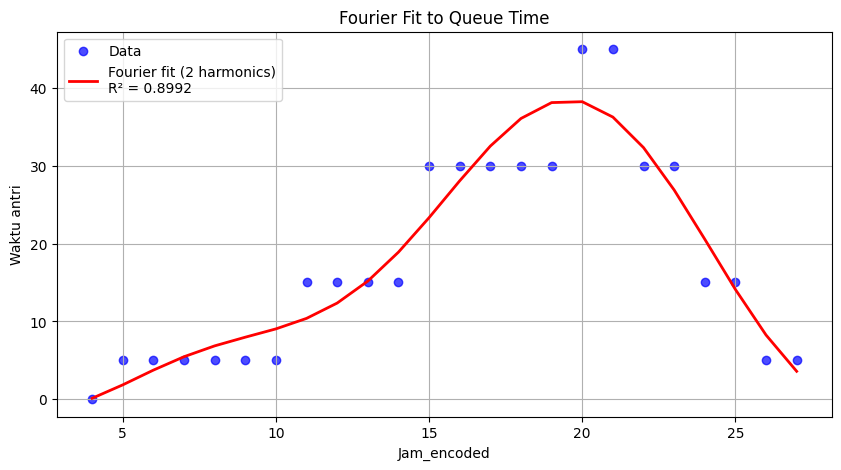

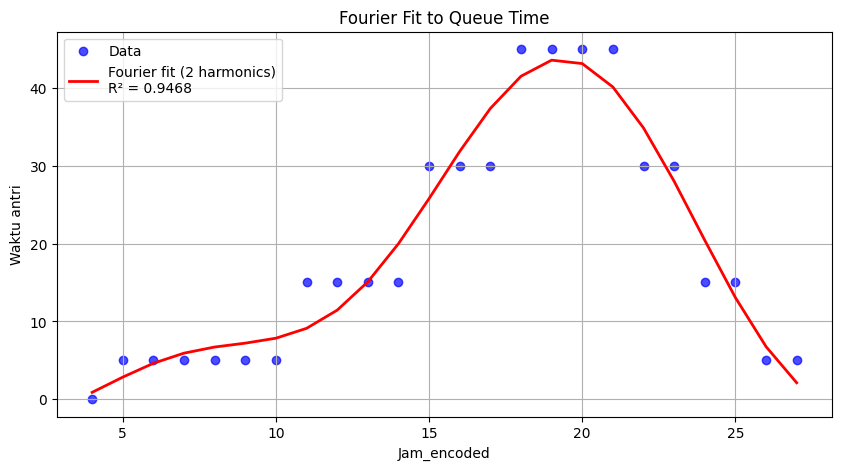

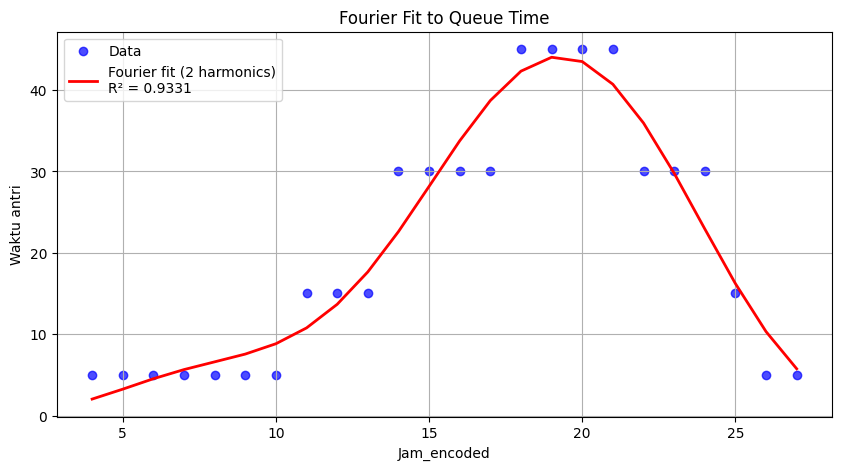

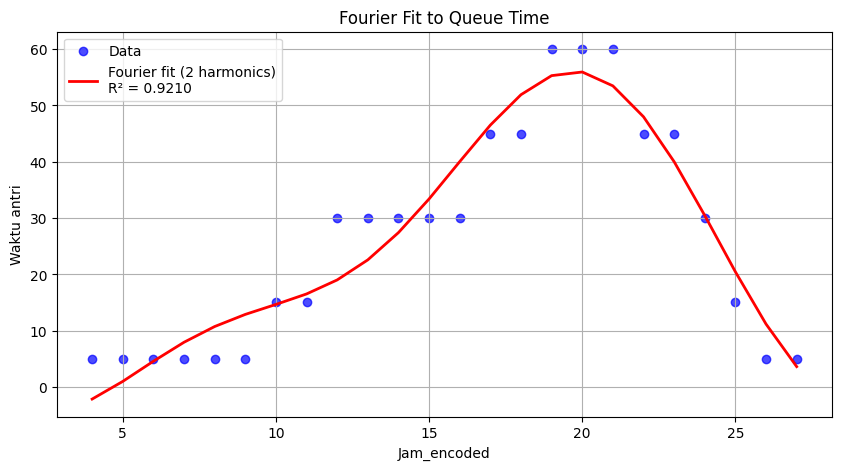

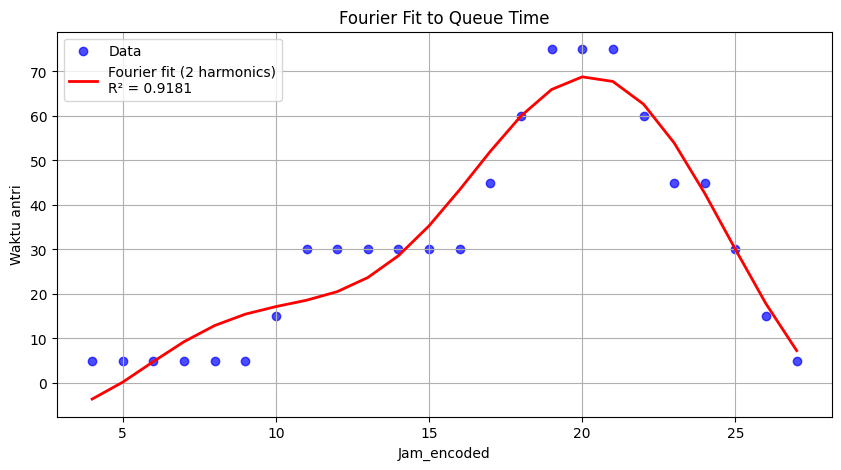

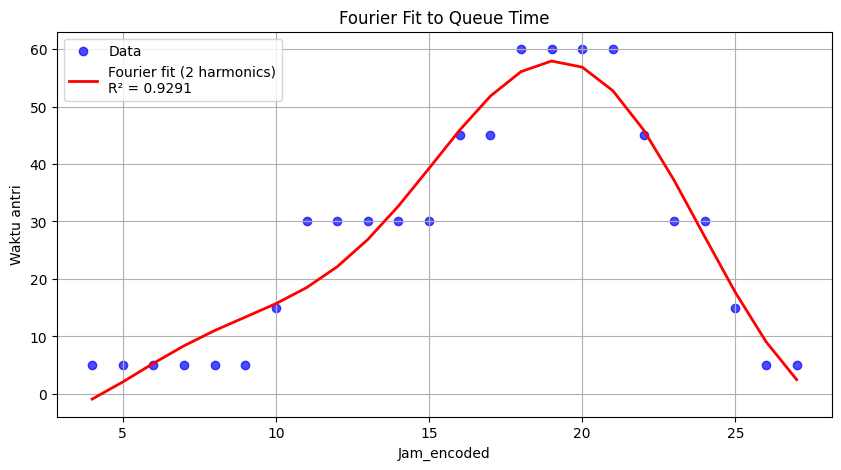

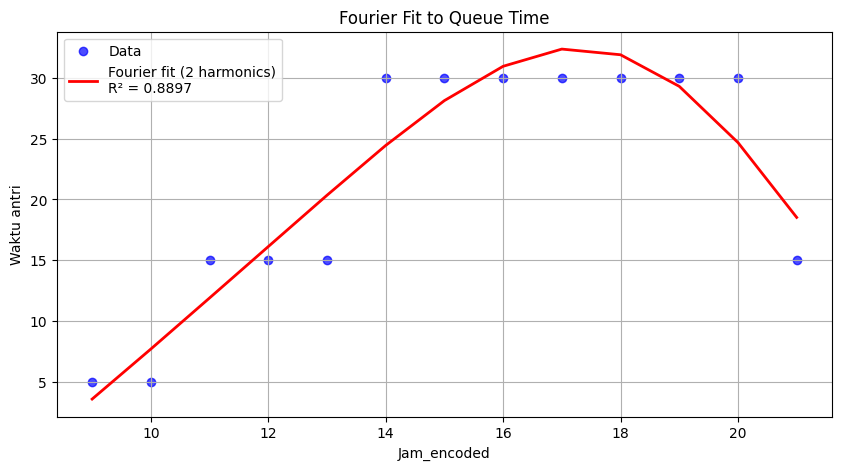

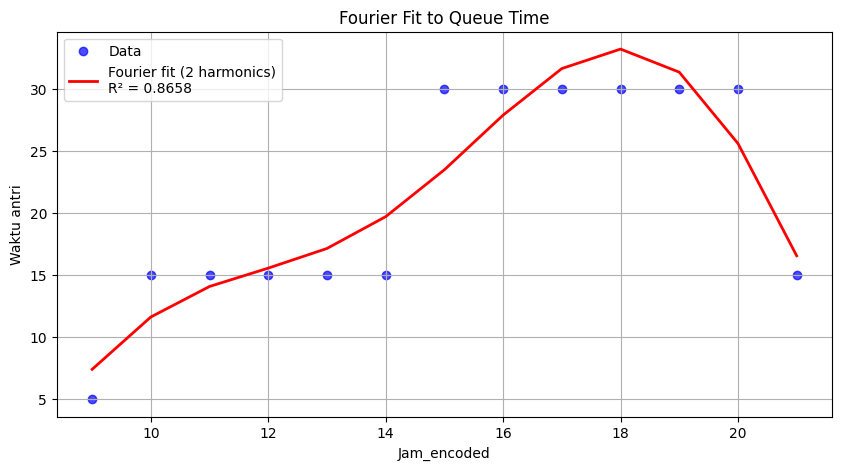

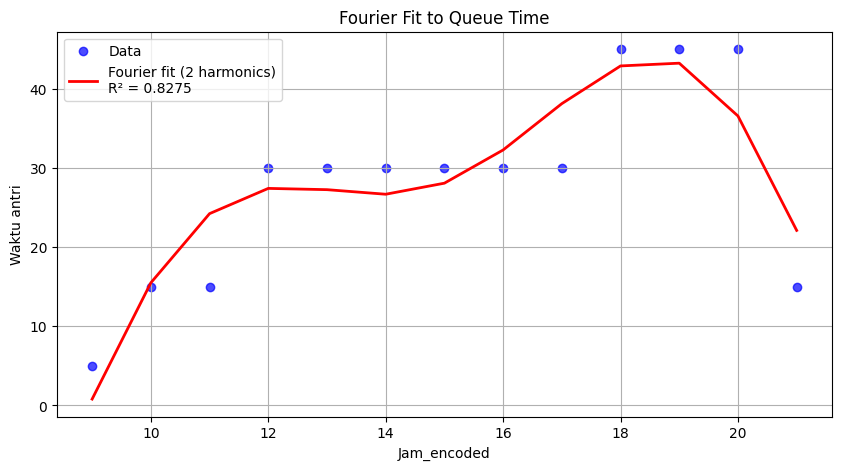

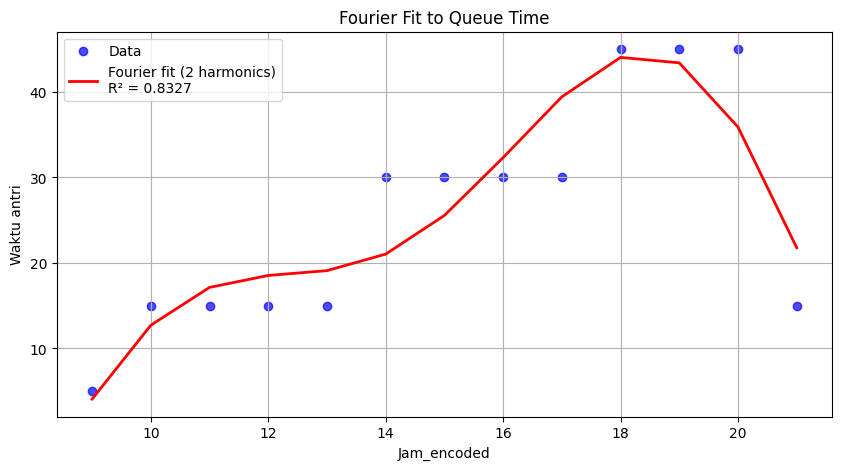

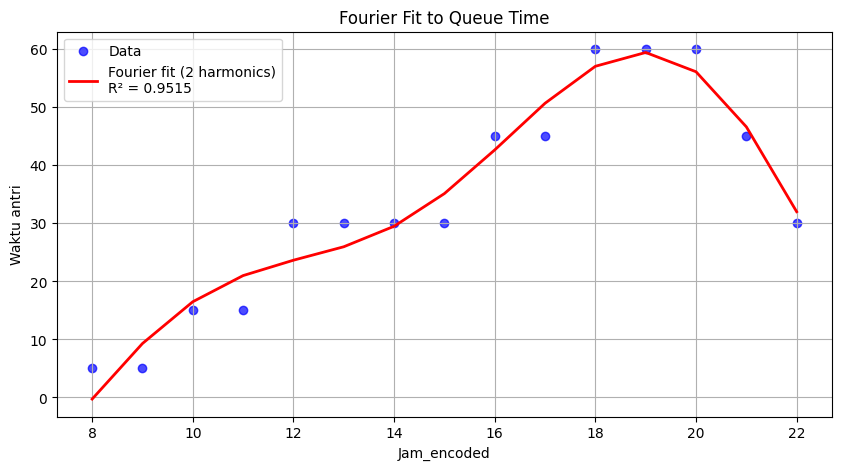

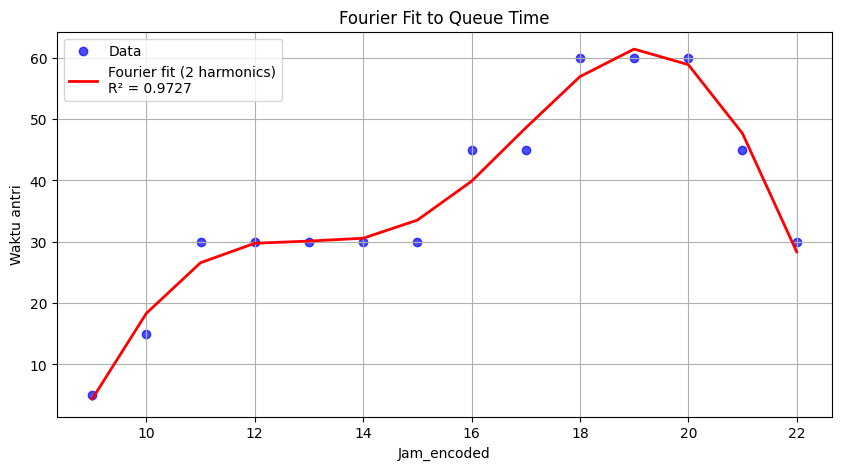

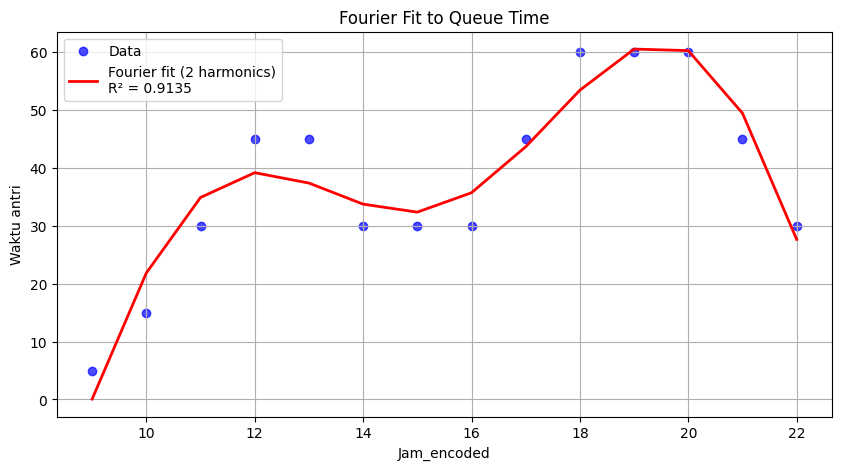

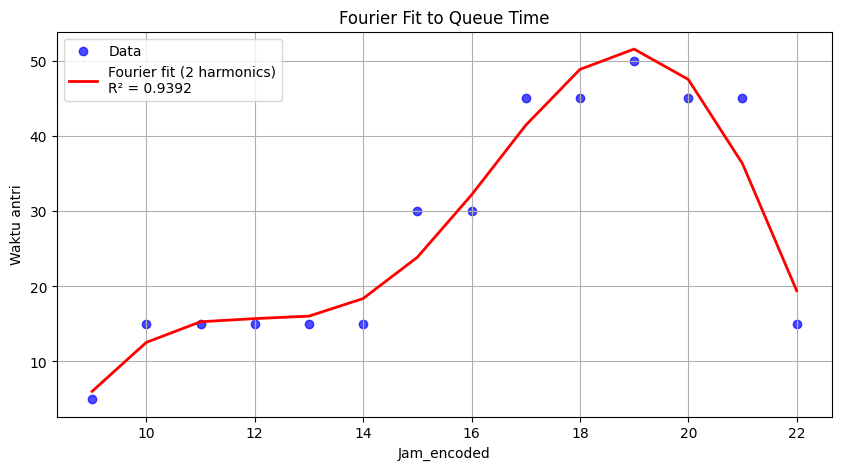

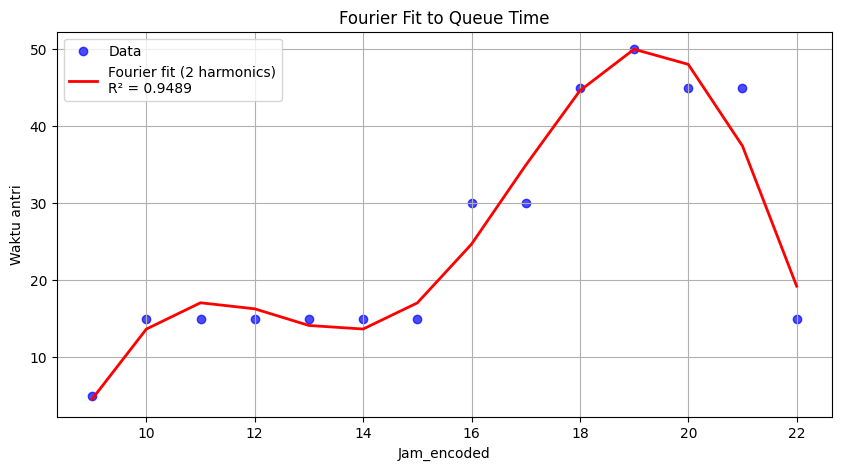

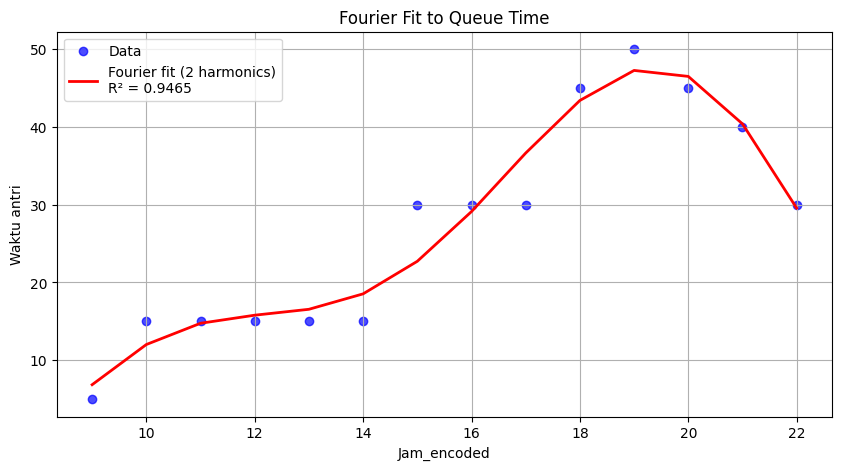

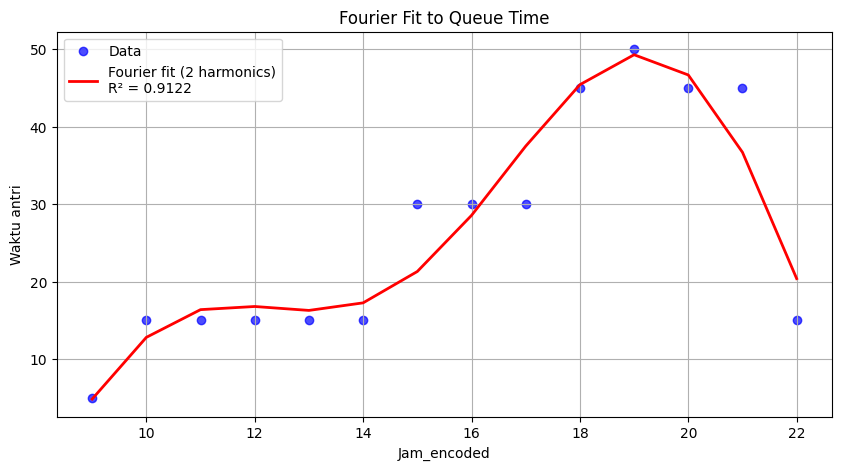

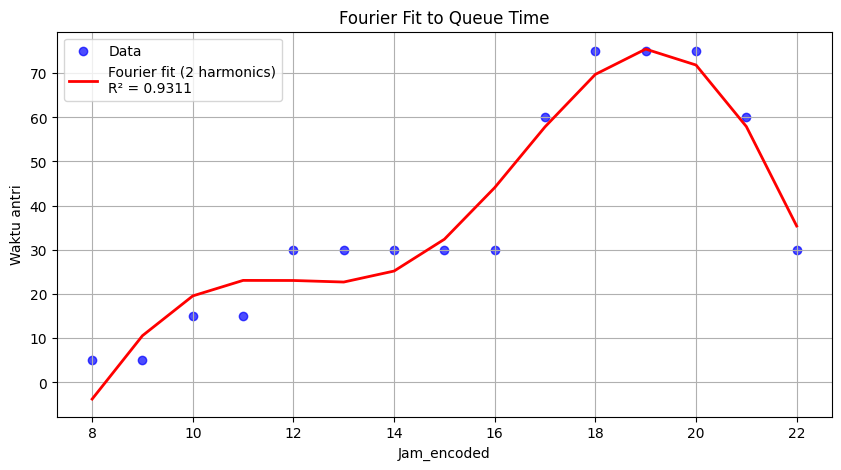

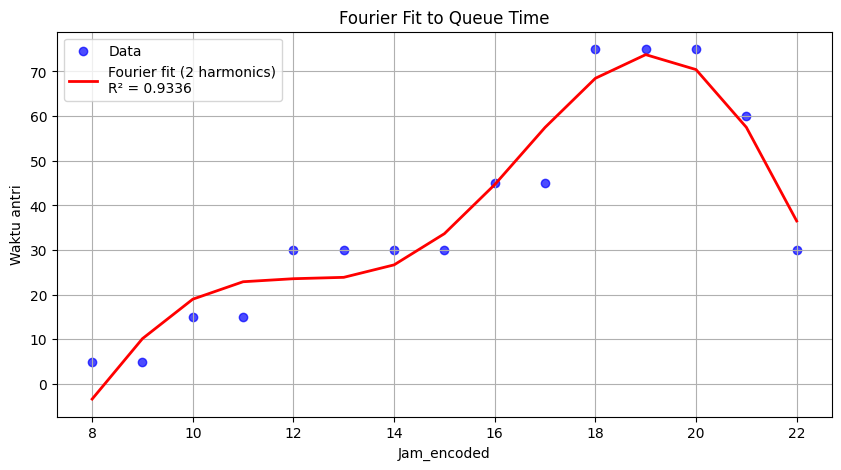

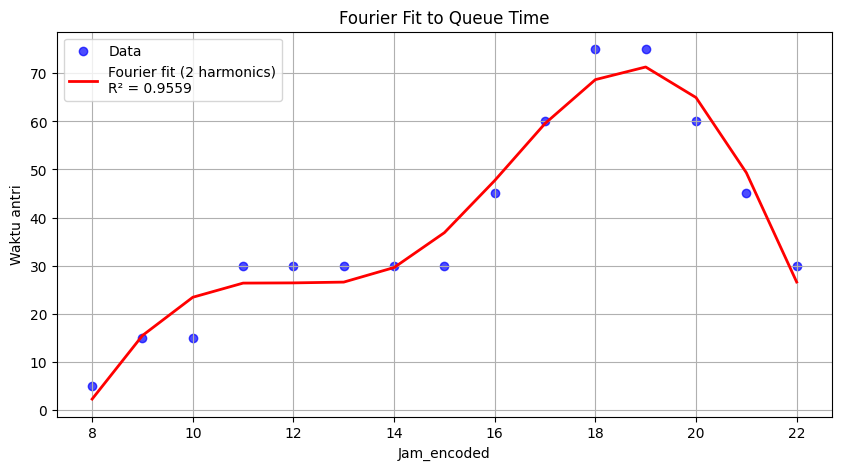

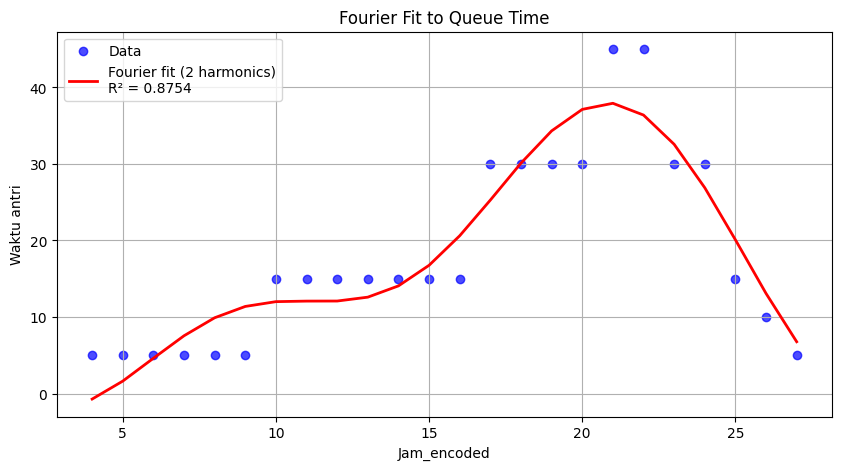

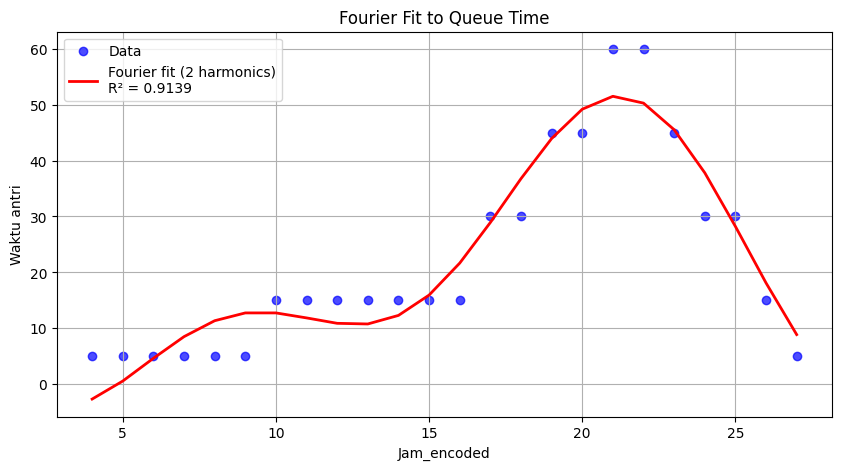

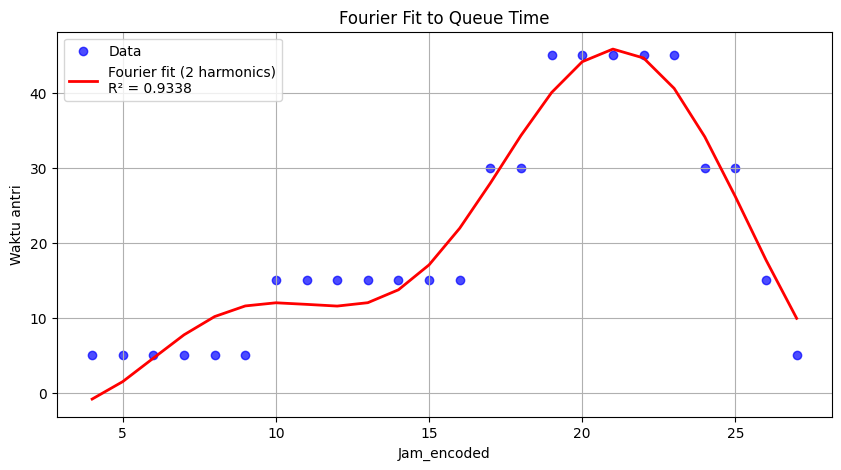

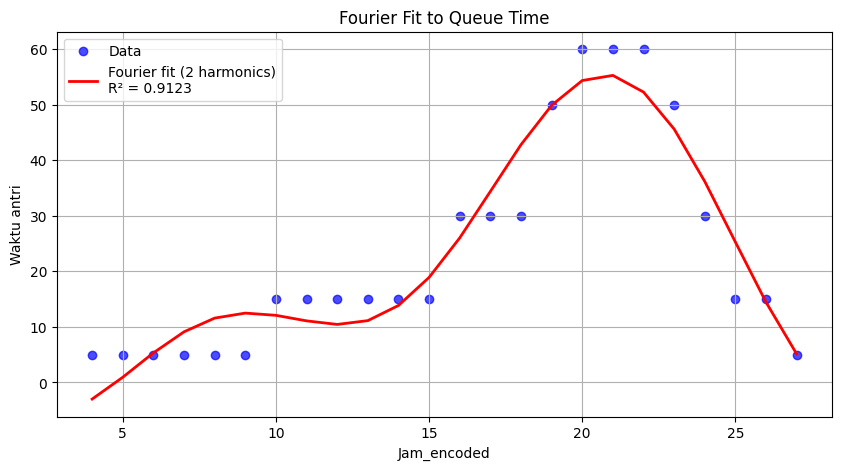

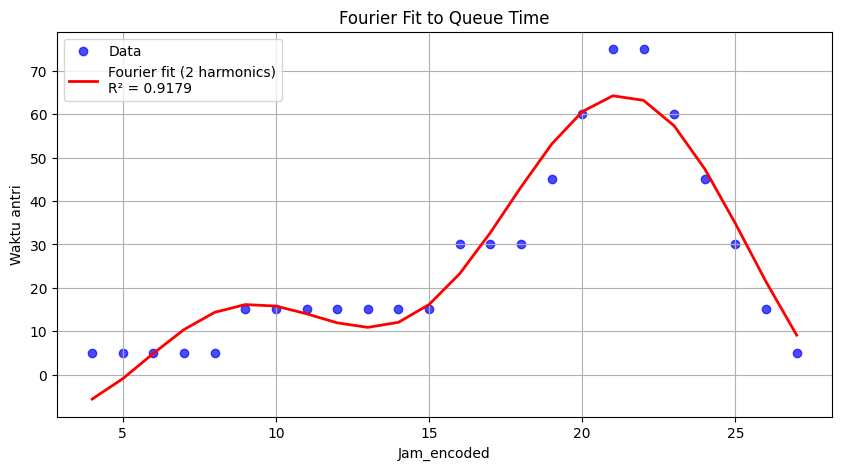

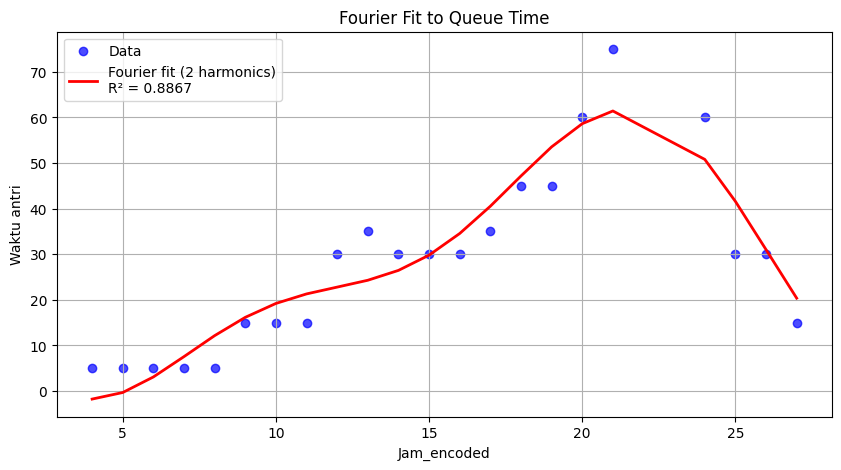

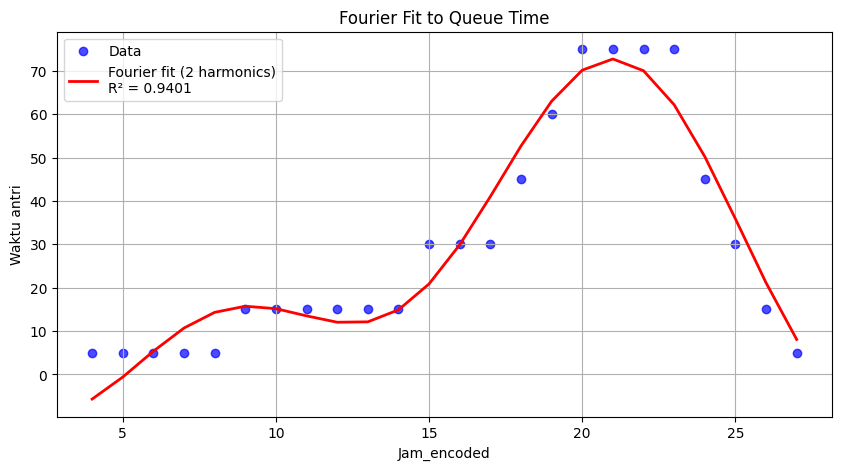

,Cabang_encoded,Hari_encoded,Coefficients,R2,Function
0,0,0,"[17.115603781917937, -15.956871305028315, -3.4...",0.906834,17.1156 + -15.9569*sin(2*pi*x/27) + -3.4223*co...
1,0,1,"[17.820964641256673, -18.270408026270125, -0.2...",0.916817,17.8210 + -18.2704*sin(2*pi*x/27) + -0.2796*co...
2,0,2,"[19.331330419996174, -22.04759259742763, -0.34...",0.912517,19.3313 + -22.0476*sin(2*pi*x/27) + -0.3439*co...
3,0,3,"[18.666259932409993, -20.624736149319578, -0.1...",0.882429,18.6663 + -20.6247*sin(2*pi*x/27) + -0.1108*co...
4,0,4,"[22.95039287707194, -28.179984772896123, -0.77...",0.906942,22.9504 + -28.1800*sin(2*pi*x/27) + -0.7736*co...
5,0,5,"[23.65369324092918, -27.747783365808214, 2.753...",0.868731,23.6537 + -27.7478*sin(2*pi*x/27) + 2.7536*cos...
6,0,6,"[19.11219567478723, -22.146584166682555, -2.85...",0.901290,19.1122 + -22.1466*sin(2*pi*x/27) + -2.8570*co...
7,1,0,"[19.207869683510783, -20.764614229668453, -7.5...",0.888942,19.2079 + -20.7646*sin(2*pi*x/27) + -7.5878*co...
8,1,1,"[19.83509602529345, -22.31224584644791, -1.773...",0.920223,19.8351 + -22.3122*sin(2*pi*x/27) + -1.7738*co...
9,1,2,"[16.54089266715701, -18.67055813352664, -6.971...",0.922443,16.5409 + -18.6706*sin(2*pi*x/27) + -6.9717*co...


In [ ]:
sfor cabang in range(7):
    for hari in range(7):
        subset = final[(final["Cabang_encoded"] == cabang) & (final["Hari_encoded"] == hari)]

        x = subset["Jam_encoded"].values
        y = subset["Waktu antri"].values

        if len(x) > 0:
            coeffs, r2 = fourier_fit_plot(x, y, n_harmonics=2)
            func_str = fourier_function_string(coeffs, x.max())
        else:
            coeffs, r2, func_str = None, None, None

        results.append({
            "Cabang_encoded": cabang,
            "Hari_encoded": hari,
            "Coefficients": coeffs,
            "R2": r2,
            "Function": func_str
        })

results_df = pd.DataFrame(results)
display(results_df)


In [ ]:
results = {}

for cabang in range(7):
    subset = results_df[results_df['Cabang_encoded'] == cabang]

    if len(subset) == 0 or subset['Coefficients'].isnull().all():
        continue

    coef_array = np.array(subset['Coefficients'].tolist())
    coef_sum = np.sum(coef_array, axis=0)
    coef_mean = coef_sum / len(subset)

    results[cabang] = {
        'sum': coef_sum,
        'mean': coef_mean,
        'count': len(subset)
    }

for cabang, vals in results.items():
    mean_coef = vals['mean']
    T = 27
    if cabang == 2:
        T = 21
    elif cabang == 4 or cabang == 5:
        T = 22

    func_str = f"{mean_coef[0]:.4f} "
    if len(mean_coef) > 1:
        func_str += f"+ ({mean_coef[1]:.4f})*sin(2*pi*x/{T}) + ({mean_coef[2]:.4f})*cos(2*pi*x/{T})"
    if len(mean_coef) > 3:
        func_str += f" + ({mean_coef[3]:.4f})*sin(4*pi*x/{T}) + ({mean_coef[4]:.4f})*cos(4*pi*x/{T})"

    print(f"Cabang {cabang}:")
    print("  Count:", vals['count'])
    print("  Mean coefficients:", mean_coef)
    print("  Function:", func_str)
    print()


Cabang 0:
  Count: 7
  Mean coefficients: [ 19.8072058  -22.1391372   -0.71907352  -7.66264335  -9.71241019]
  Function: 19.8072 + (-22.1391)*sin(2*pi*x/27) + (-0.7191)*cos(2*pi*x/27) + (-7.6626)*sin(4*pi*x/27) + (-9.7124)*cos(4*pi*x/27)

Cabang 1:
  Count: 7
  Mean coefficients: [ 21.56944602 -24.23813502  -7.14603962  -1.54427985 -10.31964712]
  Function: 21.5694 + (-24.2381)*sin(2*pi*x/27) + (-7.1460)*cos(2*pi*x/27) + (-1.5443)*sin(4*pi*x/27) + (-10.3196)*cos(4*pi*x/27)

Cabang 2:
  Count: 7
  Mean coefficients: [  0.27145847 -63.5988236    3.42992487 -10.75038972  25.6487915 ]
  Function: 0.2715 + (-63.5988)*sin(2*pi*x/21) + (3.4299)*cos(2*pi*x/21) + (-10.7504)*sin(4*pi*x/21) + (25.6488)*cos(4*pi*x/21)

Cabang 3:
  Count: 7
  Mean coefficients: [ 20.62849008 -21.43872449  -7.98539294  -0.66053885  -7.16573786]
  Function: 20.6285 + (-21.4387)*sin(2*pi*x/27) + (-7.9854)*cos(2*pi*x/27) + (-0.6605)*sin(4*pi*x/27) + (-7.1657)*cos(4*pi*x/27)

Cabang 4:
  Count: 7
  Mean coefficients: [ 

In [ ]:
mean_r2_per_cabang = {}

for cabang in range(7):
    subset = results_df[results_df['Cabang_encoded'] == cabang]
    mean_r2 = subset['R2'].mean()  # rata-rata R2
    mean_r2_per_cabang[cabang] = mean_r2
for cabang, r2 in mean_r2_per_cabang.items():
    print(f"Cabang {cabang}: rata-rata R2 ≈ {r2:.6f}")

Cabang 0: rata-rata R2 ≈ 0.899366
Cabang 1: rata-rata R2 ≈ 0.903132
Cabang 2: rata-rata R2 ≈ 0.943709
Cabang 3: rata-rata R2 ≈ 0.922719
Cabang 4: rata-rata R2 ≈ 0.893353
Cabang 5: rata-rata R2 ≈ 0.938201
Cabang 6: rata-rata R2 ≈ 0.911450


## Binning

In [ ]:
integration_plan = [
    (4, 9, [0,1, 3, 6]),
    (9, 13, [0,1, 2, 3, 4, 5, 6]),
    (13, 18, [0, 1, 2, 3, 4, 5, 6]),
    (18, 22, [0, 1, 2, 3, 4, 5, 6]),
    (22, 27, [0,1, 3, 6])
]

## Integral function

In [ ]:
matrix = np.full((7, len(integration_plan)), np.nan)

for col, (start, end, cabangs) in enumerate(integration_plan):
    for cabang in cabangs:
        mean_coef = results[cabang]['mean']

        T = 27
        if cabang == 2:
            T = 21
        elif cabang == 4 or cabang == 5:
            T = 22

        def f(x, coef=mean_coef, period=T):
            result = coef[0]
            if len(coef) > 1:
                result += coef[1]*np.sin(2*np.pi*x/period) + coef[2]*np.cos(2*np.pi*x/period)
            if len(coef) > 3:
                result += coef[3]*np.sin(4*np.pi*x/period) + coef[4]*np.cos(4*np.pi*x/period)
            return result

        integral_val, _ = quad(f, start, end)
        matrix[cabang, col] = integral_val

print("Integral matrix (rows=cabang 0-6, columns=ranges):")
print(matrix)


Integral matrix (rows=cabang 0-6, columns=ranges):
[[ 29.01286648  45.61373876 101.85869095 194.82427347 166.23652951]
 [ 31.34555398  48.7318528  160.17644846 215.92429265 132.01968779]
 [         nan  90.40273896 198.67257007 168.79039805          nan]
 [ 27.65309352  55.11519142 163.3089417  191.12527456 118.46531595]
 [         nan  71.23239842 159.33482926 167.35876636          nan]
 [         nan  69.89405582 167.39475826 204.89672407          nan]
 [ 31.22986488  54.41007104 119.63787559 205.71337227 171.37698202]]


## Insight

    (4, 9 => 3,0,6,1),
    (9, 13 => 0,1,6,3,5,4,2 ),
    (13, 18 => 0, 6, 4, 3,1,2,5 ),
    (18, 22, => 4,2,3,0,5,6,1 ),
    (22, 27, => 3,1,0,6 )